# Deep Learning - Transfer Learning & Pre-trained Models
### *Facial age recognition - a SML Regression problem*

# 1. References
1. Deep Learning with Python, 2017, Francois Chollet, section 5
2. Karen Simonyan and Andrew Zisserman, “Very Deep Convolutional Networks for Large-Scale Image Recognition,” arXiv (2014)
3. Keras transfer learning guideline, [official documentation](https://keras.io/guides/transfer_learning/#finetuning)

# 2. Initial treatment

## 2.1. Import Libraries

In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import Sequential, layers, initializers, regularizers, optimizers, metrics,losses
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.applications import VGG16, ResNet50, MobileNetV2
import keras_tuner as kt


from sklearn.utils.class_weight import compute_class_weight

import os
import time
import shutil
import random 
import zipfile
from PIL import Image
from collections import Counter
from pathlib import Path

import numpy as np
import pandas as pd
#import gdown # To download zip file from URL

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.colors import ListedColormap

2023-04-08 00:04:28.024919: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 2.2. Auxiliary functions

In [ ]:
def plot_loss(model, ylim, model_name=None):
    """
    Plots the training and validation loss curves for a single model.

    Args:
    --
    - model (keras.callbacks.History): Trained model object.
    - y_axis_range (tuple): Tuple containing the minimum and maximum y-axis values for the plot.
    - model_name (str): Optional name of the model to be included in the plot title.

    Returns:
    --
    - None

    """
# Create DataFrame object
    df_hist = pd.DataFrame.from_dict(model.history)
    df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)
    # Plot learning curves
    ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'],
                    kind="line", figsize=(6, 3), grid=True, legend=True,
                    ylabel="MSE", 
                    xlabel="Epoch", title=f"Learning curves {model_name}",                  
                    color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
    # ax.right_ax.set_ylabel("MSE")
    # ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
    ax.legend(loc=(0, -0.45), framealpha=1.0)
    ax.set_ylim(ylim)
    plt.xticks(np.arange(1, len(df_hist)+1, 1.0))

In [ ]:
def plot_all_models(dict):
    """
    Plots the training and validation loss curves for multiple models in separate subplots.

    Args:
    --
    - dict (dict): Dictionary containing trained models and their training history.

    Returns:
    --
    - None
    """
    fig, axs = plt.subplots(int(np.ceil(len(dict)/2)), 2, figsize=(20, 10))
    axs = axs.ravel() if len(dict) > 1 else [axs]

    for ax_index, model in enumerate(dict.keys()):
        df_hist = pd.DataFrame.from_dict(dict[model].history)
        df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)
        # Plot learning curves
        df_hist.plot(x="Epoch", y=['loss', 'val_loss'],
                        kind="line", figsize=(8, 12), grid=True, legend=True,
                        ylabel="MSE", 
                        xlabel="Epoch",                  
                        color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=6,
                        ax=axs[ax_index])
        axs[ax_index].set_ylim([0, 800])
        axs[ax_index].set_title(f"Learning curves {model}", fontsize=11) 
        axs[ax_index].set_xticks(np.arange(1, len(df_hist)+1, 1.0, dtype=int))  
        axs[ax_index].set_yticks(np.arange(0, 800, 100))  
        axs[ax_index].xaxis.label.set_size(8)  
        axs[ax_index].yaxis.label.set_size(8)

    plt.subplots_adjust(hspace=0.5)
    plt.show()

In [ ]:
def plot_compare_models(model_names, model_dict):
  """
  Plots the training and validation loss curves for multiple models in the same plot for comparison.

  Args:
  --
  - model_names (list): List of model names to be plotted.
  - model_dict (dict): Dictionary containing trained models and their training history.

  Returns:
  --
  - None

  """
  fig, ax = plt.subplots(figsize=(6, 3))
  colors = matplotlib.colormaps['Paired']
  color_index = 0
  for name in model_names:
      df_hist = pd.DataFrame.from_dict(model_dict[name].history)
      df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)
      ax.plot(df_hist["Epoch"], df_hist['loss'], label=f'{name} loss', color=colors(color_index))
      color_index += 1
      ax.plot(df_hist["Epoch"], df_hist['val_loss'], label=f'{name} val_loss', color=colors(color_index))
      color_index += 1
  ax.legend(loc=(-0.2, -0.6), framealpha=1.0)
  ax.set_ylabel("MSE")
  ax.set_xlabel("Epoch")
  ax.set_title(f"Compare models")
  ax.grid(True)
  ax.set_ylim([0, 800])
  plt.yticks(np.arange(0, 800, 100))
  plt.xticks(np.arange(1, len(df_hist)+1, 1.0, dtype=int))
  plt.show()

In [ ]:
def train_model(model, train_df, validation_df, epochs, batch_size, optimizer):
  ''' 
  Compiles and trains the model on the train and validation datasets.
  Additionally the training time is tracked.
  
  Args:
  --
  - model (keras.Model): A Keras model instance to be trained.
  - train_df (pandas.DataFrame): A DataFrame containing the training data.
  - validation_df (pandas.DataFrame): A DataFrame containing the validation data.
  - epochs (int): An integer representing the number of times to iterate over the entire training dataset.
  - batch_size (int): An integer representing the number of samples per gradient update.
  - optimizer (str or keras.optimizers.Optimizer): A string or an instance of a Keras optimizer to use for training.

  Returns:
  --
  - history (keras.callbacks.History): A History object containing the training loss and metric values at successive epochs, 
  as well as validation loss and metric values (if applicable).
  '''
  tf.keras.backend.clear_session()
  model.compile(optimizer=optimizer,
                loss = losses.MeanSquaredError(),
                metrics=[metrics.MeanAbsolutePercentageError(name='MAPE')]
                )

  early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
  print(f"Start training of {model.__class__.__name__}: {model.__doc__}")
  start = time.time()
  history = model.fit(train_df, validation_data=validation_df,
                      epochs=epochs, batch_size=batch_size,
                      callbacks=[early_stopping])
  print("Training time: {:.4f}s".format(time.time() - start), end="\n\n")

  return history

In [ ]:
def load_pretrained(pretrained_model):
    """
    Load the pretrained model with the correct definitions

    Args:
    --
    - model (keras.application): Trained model object.
    
    Returns:
    --
    - Downloaded instace of the pre-trained model

    """
    # Load the pretrained model
    conv_base =pretrained_model(
      weights='imagenet',
      include_top=False, # Do not include the classification layers at the top, just the convolutional base.
      input_shape=(200,200, 3)
      )
    return conv_base

In [ ]:
def extract_features(model,dataset):
    
    """
    Extracts the features from the last convolutional layer of the pretrained model.

    Args:
    --
    - model (keras.Model): A Keras model instance.
    - dataset (tf.data.Dataset): A TensorFlow dataset object.

    Returns:
    --
    - features (numpy.ndarray): A numpy array containing the extracted features.
    - labels (numpy.ndarray): A numpy array containing the labels.
    """
    shape_of_last_conv_base_layer = model.layers[-1].output_shape
    sample_count = dataset.samples
    batch_size = dataset.batch_size
    features = np.zeros(shape=(
              sample_count,
              shape_of_last_conv_base_layer[1],
              shape_of_last_conv_base_layer[2],
              shape_of_last_conv_base_layer[3])
              )
    labels = np.zeros(shape=(sample_count))
    i = 0    
    for inputs_batch, labels_batch in dataset:
        size_upper_bound = (i + 1) * batch_size
        if batch_size != len(labels_batch):
            size_upper_bound = i * batch_size + len(labels_batch)
        features_batch = model.predict(inputs_batch)
        #print(f'Lower Bound: {i * batch_size} Upper Bound: {size_upper_bound}')
        features[i * batch_size : size_upper_bound] = features_batch
        labels[i * batch_size : size_upper_bound] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
              break
    return features,labels

## 2.3. Import datasets

In [ ]:
# Define the path, where the dataset should be saved

vm_path = "/content/drive/MyDrive/
path = os.path.join(vm_path,'FacialAgeProject/')

data_path = os.path.join(path, 'data')
metadata_path = os.path.join(path, 'metadata')
dataset_path = os.path.join(data_path, "facial_age_dataset_unsplit/")

duplicated_path = os.path.join(metadata_path, 'ahash_duplicated_keys.pkl')
preprocessed_path = os.path.join(data_path, 'facial_age_dataset_preprocessed')

train_path = Path(os.path.join(preprocessed_path, 'train'))
test_path = Path(os.path.join(preprocessed_path, 'test'))

metadata_csv_path = os.path.join(metadata_path, 'images_metadata.csv')

path_save_model =  os.path.join(path,'models/best_models')

print('Train path: {}'.format(train_path))
print('Test path: {}'.format(test_path))
print('Metadata path: {}'.format(metadata_path))
print('Models path: {}'.format(path_save_model))

In [ ]:
# Image dataset with all the files configurations
images_df = pd.read_csv(metadata_csv_path)
images_df = images_df.sample(frac = 1.0).reset_index(drop = True)
images_df.head()

# Train dataset to be used in the generator
train_file_names = pd.Series(list(train_path.glob(r'**/*.png')),name = 'file_names').astype('str')
train_file_names = train_file_names.apply(lambda x : x.split('/')[-1])
train_images_df = images_df[images_df['file_name'].isin(train_file_names)]
train_images_df['file_name'] = f'{train_path}'+ '/' + train_images_df['age_label'].apply(lambda x : f"{x:03d}") + '/' + train_images_df['file_name']

# Test dataset to be used in the generator
test_file_names = pd.Series(list(test_path.glob(r'**/*.png')),name = 'file_names').astype('str')
test_file_names = test_file_names.apply(lambda x : x.split('/')[-1])
test_images_df = images_df[images_df['file_name'].isin(test_file_names)]
test_images_df['file_name'] = f'{test_path}'+ '/' + test_images_df['age_label'].apply(lambda x : f"{x:03d}") + '/' + test_images_df['file_name']

print('Train files and dataset lenght (must check) : {} vs {}'.format(len(train_file_names),train_images_df.shape[0]))
print('test files and dataset lenght (must check) : {} vs {}'.format(len(test_file_names),test_images_df.shape[0]))

Train files and dataset lenght (must check) : 6423 vs 6423
test files and dataset lenght (must check) : 1656 vs 1656


/var/folders/w0/rtcy3mbs6h38d0yjvjcd8yshb3_7pc/T/ipykernel_18748/1139155514.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_images_df['file_name'] = f'{train_path}'+ '/' + train_images_df['age_label'].apply(lambda x : f"{x:03d}") + '/' + train_images_df['file_name']
/var/folders/w0/rtcy3mbs6h38d0yjvjcd8yshb3_7pc/T/ipykernel_18748/1139155514.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_images_df['file_name'] = f'{test_path}'+ '/' + test_images_df['age_label'].apply(lambda x : f"{x:03d

In [ ]:
# Data generators and parameters
train_full_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    validation_split=0.2,
    rescale=1./255,
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

In [ ]:
# Parameters for generators
generate_params = {
    'target_size' : (200,200),
    'color_mode' : 'rgb',
    'class_mode' : 'raw',
    'batch_size' : 64,
    'seed' : 0
}

# Generators instances and data spliting
train_full_images = train_full_generator.flow_from_dataframe(
    dataframe=train_images_df,
    x_col='file_name',
    y_col='age_label',
    shuffle=True,
    **generate_params
)

train_images = train_generator.flow_from_dataframe(
    dataframe=train_images_df,
    x_col='file_name',
    y_col='age_label',
    shuffle=True,
    subset='training',
    **generate_params
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_images_df,
    x_col='file_name',
    y_col='age_label',
    shuffle=True,
    subset='validation',
    **generate_params
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_images_df,
    x_col='file_name',
    y_col='age_label',
    **generate_params
)

Found 6423 validated image filenames.
Found 5139 validated image filenames.
Found 1284 validated image filenames.
Found 1656 validated image filenames.


# 3. Transfer learning

Transfer learning is a very popular method that enables the use of models trained on top of huge datasets and very deep (and general, very computational costly) networks on other datasets (usually smaller than the ones of their trraning). This is usefull because the **features** learned by those large models can be reused in situations different than the one of the original training. This allows better performance on some tasks that has small dataset or even enrich the learning process with "pre-trained" features.

**How does it works** ? 

The usage of pre-trained models can happen in two ways : 

* Feature extraction : here we are just concerned in extract the already trained features from this pre-trained model and use them in our model. Here, the only part that is going to be trained is the final dense layer (in our case, our regression fully connected network).

* Fine tuning : here we are training the whole, or some parts, of the pre-trained model with our own samples. The hope here is that we can adapt the features generated in the convolution phase (convolutional base according to Chollett) to our own problem and yield better results.

**Implementation strategy with VGG16**

The pretrained model we are using is the VGG16. A model developed by Karen Simonyan and Andrew Zisserman [2]. The model consists on a narrow and deep network, with several stacked blocks (convolutional layers (3x3 kernels) + maxpooling).

In this section, we are implementing both ways to deal with a pre-trained model (**feature extraction** and **fine tuning** ).

Section 3.2 is implementing the feature extracting and section 3.3 the fine tuning process. By the end, the performance of both is going to be evaluated and compared in order to chose a final candidate model

## 3.1 Feature Extraction

As mentioned above, feature extraction reuse the already "learned" features from our pre-trained model (VGG16) in order to train a fully-connected network on top of it. 

There are two ways to perform this feature extraction : 

1. Extracting the features outside of the fully-connected model : In this way, we pass our whole data into the pre-trained model **a single time** and store the resulting features. These features will feed our fully-connected model and train it. The advantages of this model is that it's fast since we pass the data only one time to it but the disadvantages is that we cannot perform other transformations that requires the data to be passed more than once into the network (such as data augmentation).

2. Embedding the pre-trained model into the fully-connected model : This way, we put the dense layers on top of the pre-trained model (it is still **freezed**, so will not be trained) and run it as a whole. In this approach, the data is flowing over the pre-trained model several times, since now it is part of the model. Therefore, this approach is more expensive but can allow the insertion of other transformations.

In this section, we are performing the first one. Since we have already seen from previous notebooks (handcrafted-models) that data augmentation is a very expensive operation and it is not recommended for our specific problem. The second approach is going to be usefull in the next section of fine-tuning, though. 

In [ ]:
class PreTrained(tf.keras.Model):
    def __init__(self,
                lambda_ = 0.01,
                dp_rate = 0.5,
                dense_layers_config = ((2,4096),), # 2 dense layer with 4096 units - VGG16 arch.
                has_global_pooling = False,
                has_bn = False,
                has_max_pooling = False,
                seed=0
                 ):
        super().__init__()
        # MaxPooling layer
        if (has_max_pooling) : 
          self.max_pooling = layers.MaxPooling2D(pool_size=(2, 2), strides=2)

        # BatchNormalization layer
        if (has_bn) :
          self.bn = layers.BatchNormalization()

        # Global Pooling layer
        if (has_global_pooling) :
          self.global_pooling = layers.GlobalAveragePooling2D()

        # Dense Layers (with learnable parameters)
        self.dense = []
        for dense_layer_config in dense_layers_config :
          ff_ANN = []
          number_of_dense_layers = dense_layer_config[0]
          layer_units = dense_layer_config[1]
          for _ in range(number_of_dense_layers) :
            # Appending required number of dense layers w/ required units
            ff_ANN.append(layers.Dense(layer_units,
                                       activation="relu",
                                       kernel_regularizer=regularizers.l2(lambda_) if (lambda_ > 0) else None,))
            # Appending dropout layer if required
            if (dp_rate > 0) :
              ff_ANN.append(layers.Dropout(dp_rate, seed=seed))
          self.dense.append(ff_ANN)
        self.output_layer = layers.Dense(1,activation='linear') # Linear activation 4 regression framework

        # Non-learnable layers (define only once)
        self.flatten = layers.Flatten()
        
    def call(self, inputs):
        # MaxPooling
        if (hasattr(self, 'max_pooling')) :
          inputs = self.max_pooling(inputs)
        # BatchNormalization
        if (hasattr(self, 'bn')) :
          inputs = self.bn(inputs)
        # Flattening with GlobalMaxPooling or just Flattening
        if (hasattr(self, 'global_pooling')) :
          x = self.global_pooling(inputs)
        else :
          x = self.flatten(inputs)
        # Iterating over FullyConnected Dense layer
        for dense_layer_block in self.dense :
          for layer in dense_layer_block :
            x = layer(x)
        # Final output layer (linear)
        x = self.output_layer(x)

        return x

In [ ]:
# Pretrained model loading
pretrained_model = load_pretrained(VGG16)

# Extract features from pretrained model (convolution base)
train_features , train_labels = extract_features(pretrained_model,train_images)
val_features , val_labels = extract_features(pretrained_model,val_images)
test_features , test_labels = extract_features(pretrained_model,test_images)

2/2 [==============================] - 4s 2s/step


### 3.1.1. Regressor network modeling

The objective in this section is to model the regressor network on top of the extracted features. Different architectures are going to be explored following the guideliness from previous notebooks : implementation, evaluation, diagnose. 

### 3.1.2. Simplest regressor

This regressor is only having 1 hidden layer + output layer. The hidden layer with 1 unit.

In [ ]:
# Build the model
denser_layers_config_v1 = ((1,1),)
params = {
    'lambda_' : 0,
    'dp_rate' : 0,
    'dense_layers_config' : denser_layers_config_v1,
    'seed' : 0}
vgg16_v1 = PreTrained(**params)
vgg16_v1.build(input_shape=pretrained_model.layers[-1].output_shape)
vgg16_v1.summary()


Model: "pre_trained"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               multiple                  18433     
                                                                 
 dense_1 (Dense)             multiple                  2         
                                                                 
 flatten (Flatten)           multiple                  0         
                                                                 
Total params: 18,435
Trainable params: 18,435
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Model training

lr = 0.005
epochs = 20
batch_size = 64

vgg16_v1.compile(
    optimizer=optimizers.Adam(learning_rate=lr),
    loss = losses.MeanSquaredError(),
    metrics=[metrics.MeanAbsoluteError(name='MAE'),
             metrics.MeanAbsolutePercentageError(name='MAPE'),
             metrics.RootMeanSquaredError(name='RMSE'),
             metrics.MeanSquaredLogarithmicError(name='MSLE')]
)

history_vgg_v1 = vgg16_v1.fit(train_features,train_labels,
                                epochs=epochs,
                                batch_size=batch_size,
                                validation_data=(val_features,val_labels))

Epoch 1/20
81/81 [==============================] - 2s 11ms/step - loss: 313.6767 - MAE: 13.9697 - MAPE: 268.7563 - RMSE: 17.7109 - MSLE: 1.1369 - val_loss: 189.6590 - val_MAE: 10.5939 - val_MAPE: 158.6277 - val_RMSE: 13.7717 - val_MSLE: 0.6522
Epoch 2/20
81/81 [==============================] - 0s 5ms/step - loss: 157.8263 - MAE: 9.4870 - MAPE: 117.3079 - RMSE: 12.5629 - MSLE: 0.5685 - val_loss: 153.4895 - val_MAE: 9.4776 - val_MAPE: 140.1351 - val_RMSE: 12.3891 - val_MSLE: 0.5794
Epoch 3/20
81/81 [==============================] - 0s 5ms/step - loss: 128.3335 - MAE: 8.4494 - MAPE: 99.6772 - RMSE: 11.3284 - MSLE: 0.4952 - val_loss: 132.8931 - val_MAE: 8.4608 - val_MAPE: 93.7388 - val_RMSE: 11.5279 - val_MSLE: 0.5140
Epoch 4/20
81/81 [==============================] - 0s 5ms/step - loss: 109.1241 - MAE: 7.7104 - MAPE: 82.5928 - RMSE: 10.4462 - MSLE: 0.4504 - val_loss: 125.0825 - val_MAE: 8.3584 - val_MAPE: 114.9321 - val_RMSE: 11.1840 - val_MSLE: 0.5040
Epoch 5/20
81/81 [==============

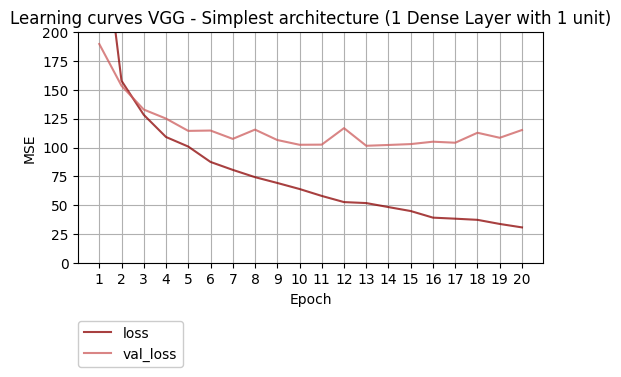

In [ ]:
# Model evaluation

plot_loss(history_vgg_v1,(0,200), 'VGG - Simplest architecture (1 Dense Layer with 1 unit)')

Observation : 

Even with only this very simple architecture, the model is not able to control overfit. Seems that this is going to be the problem to deal with in the following trials. A possible explanation for this overfit is the big numbers of parameters in the dense layers compared to the number of samples (18k vs 5k). It could be a good idea to reduce the size of the features using a maxpooling operation just before flattening or use the global max polling instead of flatten.

### 3.1.3. Decrease input size of the network

In [ ]:
# Build the model
denser_layers_config_v1_1 = ((1,1),)
params = {
    'lambda_' : 0,
    'dp_rate' : 0,
    'dense_layers_config' : denser_layers_config_v1_1,
    'has_max_pooling' : True,
    'seed' : 0}
vgg16_v1_1 = PreTrained(**params)
vgg16_v1_1.build(input_shape=pretrained_model.layers[-1].output_shape)
vgg16_v1_1.summary()


Model: "pre_trained_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 max_pooling2d (MaxPooling2D  multiple                 0         
 )                                                               
                                                                 
 dense_8 (Dense)             multiple                  4609      
                                                                 
 dense_9 (Dense)             multiple                  2         
                                                                 
 flatten_4 (Flatten)         multiple                  0         
                                                                 
Total params: 4,611
Trainable params: 4,611
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Model training

lr = 0.005
epochs = 20
batch_size = 64

vgg16_v1_1.compile(
    optimizer=optimizers.Adam(learning_rate=lr),
    loss = losses.MeanSquaredError(),
    metrics=[metrics.MeanAbsoluteError(name='MAE'),
             metrics.MeanAbsolutePercentageError(name='MAPE'),
             metrics.RootMeanSquaredError(name='RMSE'),
             metrics.MeanSquaredLogarithmicError(name='MSLE')]
)

history_vgg_v1_1 = vgg16_v1_1.fit(train_features,train_labels,
                                epochs=epochs,
                                batch_size=batch_size,
                                validation_data=(val_features,val_labels))

Epoch 1/20
81/81 [==============================] - 2s 10ms/step - loss: 398.9386 - MAE: 15.4094 - MAPE: 269.4166 - RMSE: 19.9734 - MSLE: 1.8167 - val_loss: 207.2467 - val_MAE: 11.1062 - val_MAPE: 172.8963 - val_RMSE: 14.3961 - val_MSLE: 0.6976
Epoch 2/20
81/81 [==============================] - 0s 3ms/step - loss: 176.7111 - MAE: 10.1296 - MAPE: 135.9844 - RMSE: 13.2933 - MSLE: 0.6163 - val_loss: 165.2095 - val_MAE: 9.6627 - val_MAPE: 127.7143 - val_RMSE: 12.8534 - val_MSLE: 0.5695
Epoch 3/20
81/81 [==============================] - 0s 3ms/step - loss: 145.7825 - MAE: 9.0801 - MAPE: 110.2672 - RMSE: 12.0740 - MSLE: 0.5348 - val_loss: 147.2966 - val_MAE: 9.2338 - val_MAPE: 128.5482 - val_RMSE: 12.1366 - val_MSLE: 0.5461
Epoch 4/20
81/81 [==============================] - 0s 3ms/step - loss: 127.9043 - MAE: 8.4656 - MAPE: 100.5923 - RMSE: 11.3095 - MSLE: 0.4907 - val_loss: 136.0828 - val_MAE: 8.5531 - val_MAPE: 91.1430 - val_RMSE: 11.6655 - val_MSLE: 0.4898
Epoch 5/20
81/81 [===========

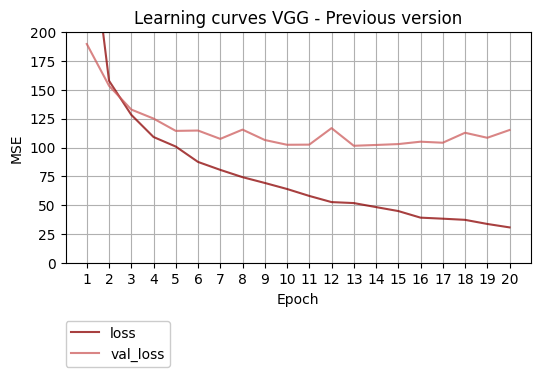

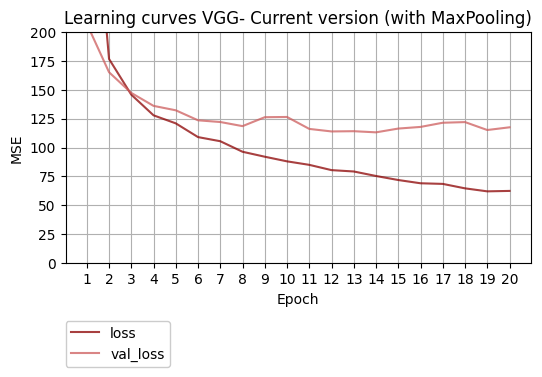

In [ ]:
# Model evaluation
plot_loss(history_vgg_v1,(0,200),'VGG - Previous version')
plot_loss(history_vgg_v1_1,(0,200), 'VGG- Current version (with MaxPooling)')

Observation :
Seems like the overfitting decrease a little with this approach but it still exists, specially in the final layers. We can still try other approachs to control the overfitting such as L2 regularization.

### 3.1.4. Controling overfitting with L2 regularization

In [ ]:
# Build the model
denser_layers_config_v2 = ((1,1),)
params = {
    'lambda_' : 5e-3,
    'dp_rate' : 0,
    'has_max_pooling' : True,
    'dense_layers_config' : denser_layers_config_v2,
    'seed' : 0}
vgg16_v2 = PreTrained(**params)
vgg16_v2.build(input_shape=pretrained_model.layers[-1].output_shape)
vgg16_v2.summary()


Model: "pre_trained_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 max_pooling2d_1 (MaxPooling  multiple                 0         
 2D)                                                             
                                                                 
 dense_10 (Dense)            multiple                  4609      
                                                                 
 dense_11 (Dense)            multiple                  2         
                                                                 
 flatten_5 (Flatten)         multiple                  0         
                                                                 
Total params: 4,611
Trainable params: 4,611
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Model training
lr = 0.005
epochs = 20
batch_size = 64

vgg16_v2.compile(
    optimizer=optimizers.Adam(learning_rate=lr),
    loss = losses.MeanSquaredError(),
    metrics=[metrics.MeanAbsoluteError(name='MAE'),
             metrics.MeanAbsolutePercentageError(name='MAPE'),
             metrics.RootMeanSquaredError(name='RMSE'),
             metrics.MeanSquaredLogarithmicError(name='MSLE')]
)

history_vgg_v2 = vgg16_v2.fit(train_features,train_labels,
                                epochs=epochs,
                                batch_size=batch_size,
                                validation_data=(val_features,val_labels))

Epoch 1/20
81/81 [==============================] - 1s 8ms/step - loss: 413.6617 - MAE: 16.5730 - MAPE: 345.3706 - RMSE: 20.3366 - MSLE: 1.5904 - val_loss: 254.1368 - val_MAE: 12.7417 - val_MAPE: 234.8813 - val_RMSE: 15.9344 - val_MSLE: 0.8599
Epoch 2/20
81/81 [==============================] - 0s 3ms/step - loss: 207.2159 - MAE: 11.1973 - MAPE: 172.8877 - RMSE: 14.3821 - MSLE: 0.7062 - val_loss: 190.5496 - val_MAE: 10.3783 - val_MAPE: 142.5703 - val_RMSE: 13.7862 - val_MSLE: 0.6391
Epoch 3/20
81/81 [==============================] - 0s 4ms/step - loss: 170.0731 - MAE: 9.8815 - MAPE: 126.9426 - RMSE: 13.0189 - MSLE: 0.6054 - val_loss: 170.7646 - val_MAE: 10.1133 - val_MAPE: 156.9849 - val_RMSE: 13.0416 - val_MSLE: 0.6328
Epoch 4/20
81/81 [==============================] - 0s 3ms/step - loss: 147.3645 - MAE: 9.1186 - MAPE: 110.9170 - RMSE: 12.1071 - MSLE: 0.5414 - val_loss: 155.6634 - val_MAE: 9.5652 - val_MAPE: 139.8962 - val_RMSE: 12.4412 - val_MSLE: 0.5673
Epoch 5/20
81/81 [=========

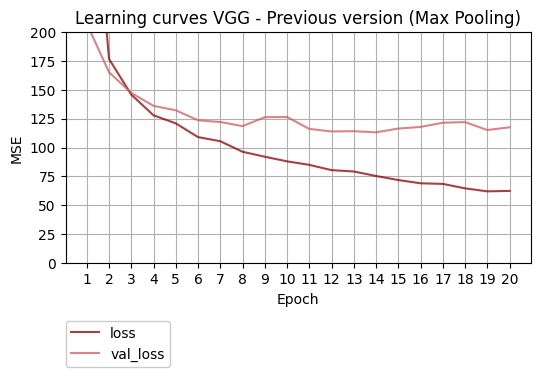

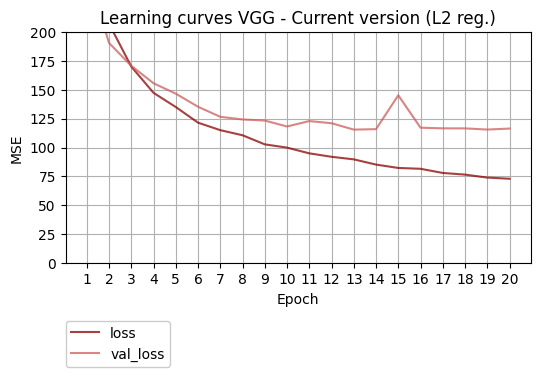

In [ ]:
plot_loss(history_vgg_v1_1,(0,200),'VGG - Previous version (Max Pooling)')
plot_loss(history_vgg_v2,(0,200),'VGG - Current version (L2 reg.)')

Observation :
Using the L2 regulazation seems to control even more the overfitting compared to the last approach. Another approach to control the overfit could be using the dropout layer. This would not make much sense to use it in a very narrow dense layer such as the one we are using (1 unit). So, to try dropout we could increase the number of units and apply a dropout rate, this could potentially control overfitting and increase the model performance (by increasing the network sie) in the same time.

### 3.1.5. Increasing the size of the dense architecture and use dropout regularization

In [ ]:
# Build the model
denser_layers_config_v2_1 = ((1,32),)
params = {
    'lambda_' : 0,
    'dp_rate' : 0.2,
    'has_max_pooling' : True,
    'dense_layers_config' : denser_layers_config_v2_1,
    'seed' : 0}
vgg16_v2_1 = PreTrained(**params)
vgg16_v2_1.build(input_shape=pretrained_model.layers[-1].output_shape)
vgg16_v2_1.summary()


Model: "pre_trained_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 max_pooling2d_5 (MaxPooling  multiple                 0         
 2D)                                                             
                                                                 
 dense_18 (Dense)            multiple                  147488    
                                                                 
 dropout_6 (Dropout)         multiple                  0         
                                                                 
 dense_19 (Dense)            multiple                  33        
                                                                 
 flatten_9 (Flatten)         multiple                  0         
                                                                 
Total params: 147,521
Trainable params: 147,521
Non-trainable params: 0
_______________________________________________

In [ ]:
lr = 0.005
epochs = 20
batch_size = 64

vgg16_v2_1.compile(
    optimizer=optimizers.Adam(learning_rate=lr),
    loss = losses.MeanSquaredError(),
    metrics=[metrics.MeanAbsoluteError(name='MAE'),
             metrics.MeanAbsolutePercentageError(name='MAPE'),
             metrics.RootMeanSquaredError(name='RMSE'),
             metrics.MeanSquaredLogarithmicError(name='MSLE')]
)

history_vgg_v2_1 = vgg16_v2_1.fit(train_features,train_labels,
                                epochs=epochs,
                                batch_size=batch_size,
                                validation_data=(val_features,val_labels))

Epoch 1/20
81/81 [==============================] - 2s 12ms/step - loss: 347.3208 - MAE: 14.5790 - MAPE: 261.0862 - RMSE: 18.6365 - MSLE: 1.1314 - val_loss: 200.0028 - val_MAE: 10.4580 - val_MAPE: 127.9271 - val_RMSE: 14.1422 - val_MSLE: 0.5083
Epoch 2/20
81/81 [==============================] - 0s 6ms/step - loss: 189.3105 - MAE: 10.2071 - MAPE: 120.5920 - RMSE: 13.7590 - MSLE: 0.5119 - val_loss: 150.4752 - val_MAE: 9.0281 - val_MAPE: 103.2901 - val_RMSE: 12.2668 - val_MSLE: 0.4193
Epoch 3/20
81/81 [==============================] - 0s 6ms/step - loss: 156.6694 - MAE: 9.1329 - MAPE: 95.4344 - RMSE: 12.5168 - MSLE: 0.4148 - val_loss: 131.6134 - val_MAE: 8.3935 - val_MAPE: 105.4154 - val_RMSE: 11.4723 - val_MSLE: 0.4003
Epoch 4/20
81/81 [==============================] - 0s 5ms/step - loss: 148.6425 - MAE: 8.8679 - MAPE: 93.4458 - RMSE: 12.1919 - MSLE: 0.3900 - val_loss: 135.0959 - val_MAE: 8.2890 - val_MAPE: 80.8506 - val_RMSE: 11.6231 - val_MSLE: 0.3601
Epoch 5/20
81/81 [=============

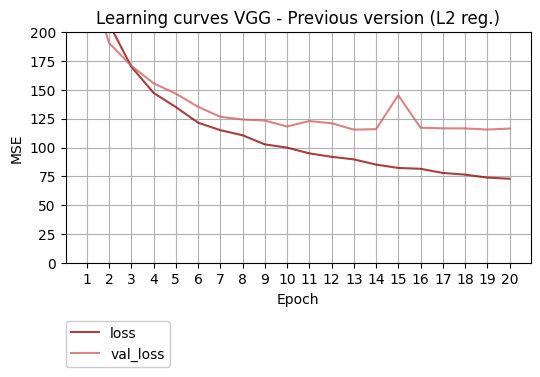

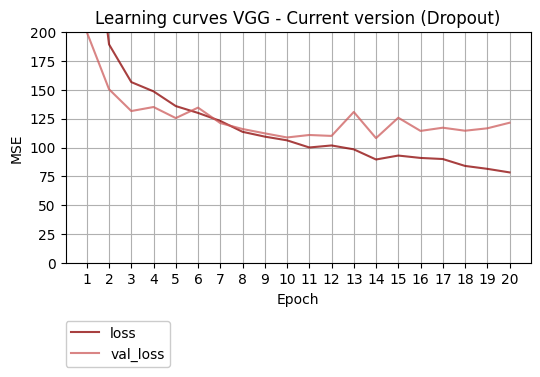

In [ ]:
plot_loss(history_vgg_v2,(0,200),'VGG - Previous version (L2 reg.)')
plot_loss(history_vgg_v2_1,(0,200),'VGG - Current version (Dropout)')

Observation : 
This approach seems to be the one that best controls the overfiting. In the final step, we could reduce the number of epochs since it seems to be overfiting in the final ones. Maybe around 12 epochs is enough.

### 3.1.6. Decreasing the number of epochs

In [ ]:
# Build the model
denser_layers_config_v3 = ((1,32),)
params = {
    'lambda_' : 0,
    'dp_rate' : 0.2,
    'dense_layers_config' : denser_layers_config_v3,
    'has_max_pooling' : True,
    'seed' : 0}
vgg16_v3 = PreTrained(**params)
vgg16_v3.build(input_shape=pretrained_model.layers[-1].output_shape)
vgg16_v3.summary()


Model: "pre_trained_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 max_pooling2d_7 (MaxPooling  multiple                 0         
 2D)                                                             
                                                                 
 dense_22 (Dense)            multiple                  147488    
                                                                 
 dropout_8 (Dropout)         multiple                  0         
                                                                 
 dense_23 (Dense)            multiple                  33        
                                                                 
 flatten_11 (Flatten)        multiple                  0         
                                                                 
Total params: 147,521
Trainable params: 147,521
Non-trainable params: 0
______________________________________________

In [ ]:
lr = 0.005
epochs = 10
batch_size = 64

vgg16_v3.compile(
    optimizer=optimizers.Adam(learning_rate=lr),
    loss = losses.MeanSquaredError(),
    metrics=[metrics.MeanAbsoluteError(name='MAE'),
             metrics.MeanAbsolutePercentageError(name='MAPE'),
             metrics.RootMeanSquaredError(name='RMSE'),
             metrics.MeanSquaredLogarithmicError(name='MSLE')]
)

history_vgg_v3 = vgg16_v3.fit(train_features,train_labels,
                                epochs=epochs,
                                batch_size=batch_size,
                                validation_data=(val_features,val_labels))

Epoch 1/10
81/81 [==============================] - 1s 11ms/step - loss: 268.7937 - MAE: 12.5035 - MAPE: 201.5911 - RMSE: 16.3949 - MSLE: 0.8521 - val_loss: 159.2072 - val_MAE: 9.5907 - val_MAPE: 150.9268 - val_RMSE: 12.6177 - val_MSLE: 0.5395
Epoch 2/10
81/81 [==============================] - 0s 6ms/step - loss: 160.9886 - MAE: 9.3054 - MAPE: 104.9931 - RMSE: 12.6881 - MSLE: 0.4290 - val_loss: 130.6769 - val_MAE: 8.3020 - val_MAPE: 99.6134 - val_RMSE: 11.4314 - val_MSLE: 0.3709
Epoch 3/10
81/81 [==============================] - 0s 5ms/step - loss: 140.1138 - MAE: 8.6446 - MAPE: 91.9109 - RMSE: 11.8370 - MSLE: 0.3797 - val_loss: 124.3589 - val_MAE: 7.9086 - val_MAPE: 77.7284 - val_RMSE: 11.1516 - val_MSLE: 0.3370
Epoch 4/10
81/81 [==============================] - 0s 5ms/step - loss: 138.3898 - MAE: 8.4988 - MAPE: 85.0211 - RMSE: 11.7639 - MSLE: 0.3679 - val_loss: 118.9440 - val_MAE: 7.7554 - val_MAPE: 82.8070 - val_RMSE: 10.9061 - val_MSLE: 0.3114
Epoch 5/10
81/81 [=================

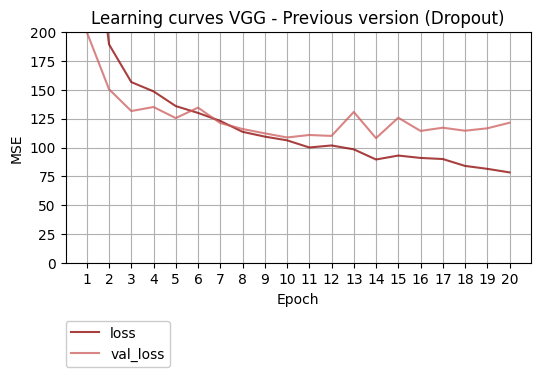

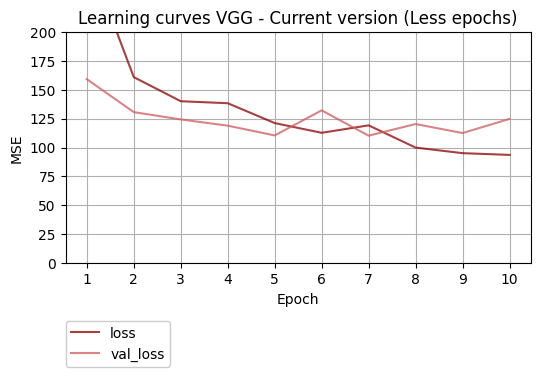

In [ ]:
plot_loss(history_vgg_v2_1,(0,200),'VGG - Previous version (Dropout)')
plot_loss(history_vgg_v3,(0,200),'VGG - Current version (Less epochs)')

Observation : 
As expected, decreasing the number of epochs resulted in a model with less overfiting. So far, it seems to be the best model. 
As a final approach, lets explora a different architecture. Lets use global aberage pooling to drasticallly reduce the dimension of the features and with that we can have ore degrees of fredom to train a deeper regressor.

### 3.1.7. Global average pooling + deeper regressor

In [ ]:
# Build the model
denser_layers_config_v5 = ((1,32),(1,16),)
params = {
    'lambda_' : 0,
    'dp_rate' : 0.0,
    'dense_layers_config' : denser_layers_config_v5,
    'has_bn' : True,
    'has_global_pooling' : True,
    'seed' : 0}
vgg16_v5 = PreTrained(**params)
vgg16_v5.build(input_shape=pretrained_model.layers[-1].output_shape)
vgg16_v5.summary()


Model: "pre_trained_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_2 (Batc  multiple                 2048      
 hNormalization)                                                 
                                                                 
 global_average_pooling2d_7   multiple                 0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_47 (Dense)            multiple                  16416     
                                                                 
 dense_48 (Dense)            multiple                  528       
                                                                 
 dense_49 (Dense)            multiple                  17        
                                                                 
 flatten_19 (Flatten)        multiple               

In [ ]:
lr = 0.001
epochs = 40
batch_size = 64

vgg16_v5.compile(
    optimizer=optimizers.Adam(learning_rate=lr),
    loss = losses.MeanSquaredError(),
    metrics=[metrics.MeanAbsoluteError(name='MAE'),
             metrics.MeanAbsolutePercentageError(name='MAPE'),
             metrics.RootMeanSquaredError(name='RMSE'),
             metrics.MeanSquaredLogarithmicError(name='MSLE')]
)

history_vgg_v5 = vgg16_v5.fit(train_features,train_labels,
                                epochs=epochs,
                                batch_size=batch_size,
                                validation_data=(val_features,val_labels))

Epoch 1/40
81/81 [==============================] - 3s 19ms/step - loss: 752.9605 - MAE: 20.4601 - MAPE: 125.9608 - RMSE: 27.4401 - MSLE: 2.9284 - val_loss: 411.0351 - val_MAE: 15.6459 - val_MAPE: 211.0045 - val_RMSE: 20.2740 - val_MSLE: 0.9317
Epoch 2/40
81/81 [==============================] - 1s 15ms/step - loss: 237.3015 - MAE: 12.0766 - MAPE: 194.6101 - RMSE: 15.4046 - MSLE: 0.7876 - val_loss: 299.6126 - val_MAE: 13.7020 - val_MAPE: 216.7671 - val_RMSE: 17.3093 - val_MSLE: 0.8454
Epoch 3/40
81/81 [==============================] - 2s 20ms/step - loss: 199.2174 - MAE: 10.8355 - MAPE: 155.4588 - RMSE: 14.1144 - MSLE: 0.6342 - val_loss: 239.7313 - val_MAE: 12.1403 - val_MAPE: 190.4690 - val_RMSE: 15.4833 - val_MSLE: 0.7165
Epoch 4/40
81/81 [==============================] - 1s 15ms/step - loss: 176.5621 - MAE: 10.0048 - MAPE: 135.0314 - RMSE: 13.2877 - MSLE: 0.5434 - val_loss: 197.9026 - val_MAE: 10.9269 - val_MAPE: 164.0105 - val_RMSE: 14.0678 - val_MSLE: 0.6089
Epoch 5/40
81/81 [==

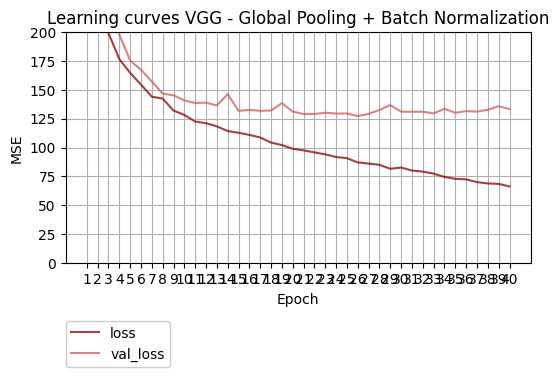

In [ ]:
plot_loss(history_vgg_v5,(0,200),'VGG - Global Pooling + Batch Normalization')

Observation :
This approach seems to have a smoother landscape, because of the batchnormalization applied. But it's not better neither in terms of overfiting or performance than our last model

### 3.1.8. Conclusion

In this section many different models were explored with the main goal of reducing the overfit. The best approach was the one presented in 3.1.5., where a bigger dense layer was used followed by a dropout layer. We have also decresed the number of epochs in order to prevent even further the overfit.

The performance of the models is something that we could not improve with the regressor architecture. A possibility to improve it could be through fine tuning the VGG16 with our own data. This topic is covered in the next section.

## 3.2. Fine Tuning

In this section we are exploring the fine tuning of the pre-trained model. Our hope is that with that we can improve the performance of the pre-trained model by providing our own data and adjusting the model's weight according to that.

In order to do the finetuning we must, according to Chollett: 

1. Add your custom network on top of an already-trained base network.
2. Freeze the base network.
3. Train the part you added.
4. Unfreeze some layers in the base network.
5. Jointly train both these layers and the part you added.

Our best model architecture found in the previous step will be used in this stage.

Notice that our approach with feature extraction is not adequate for fine tuning. For that we need embed the pre-trained model with the regressor model. So when it is trained, both the pre-trained and regressor are trained.

One important thing : We must train the regressor first, with the pre-trained model freezed and, only then, train it again with the pre-trained, or just some layers of it, unfreezed. This is important because, according to Chollett: 
> "it’s only possible to fine-tune the top layers of the convolutional base once the classifier on top has already been trained. If the classifier isn’t already trained, then the error signal propagating through the network during training will be too large, and the represen- tations previously learned by the layers being fine-tuned will be destroyed." [1]





In [ ]:
class PreTrained_FineTuning(tf.keras.Model):
    def __init__(
          self, seed=0, pretrained_model=None,
          lambda_ = 0.01, dp_rate = 0.5, has_bn = False,
          has_global_pooling = False, dense_layers_config = ((2,4096),)):
        super().__init__()

        # Pretrained model <- including the VGG16 inside of our model
        self.base_model = pretrained_model

        # BatchNormalization layer
        if (has_bn) :
          self.bn = layers.BatchNormalization()

        # Global Pooling layer
        if (has_global_pooling) :
          self.global_pooling = layers.GlobalAveragePooling2D()

        # Dense Layers (with learnable parameters)
        self.dense = []
        for dense_layer_config in dense_layers_config :
          ff_ANN = []
          number_of_dense_layers = dense_layer_config[0]
          layer_units = dense_layer_config[1]
          for _ in range(number_of_dense_layers) :
            # Appending required number of dense layers w/ required units
            ff_ANN.append(layers.Dense(layer_units,
                                       activation="relu",
                                       kernel_regularizer=regularizers.l2(lambda_) if (lambda_ > 0) else None,))
            # Appending dropout layer if required
            if (dp_rate > 0) :
              ff_ANN.append(layers.Dropout(dp_rate, seed=seed))
          self.dense.append(ff_ANN)
        self.output_layer = layers.Dense(1,activation='linear') # Linear activation 4 regression framework

        # Non-learnable layers (define only once)
        self.flatten = layers.Flatten()
        
    def call(self, inputs):
        # Pretrained model
        inputs = self.base_model(inputs)
        # BatchNormalization
        if (hasattr(self, 'bn')) :
          inputs = self.bn(inputs)
        # Flattening with GlobalMaxPooling or just Flattening
        if (hasattr(self, 'global_pooling')) :
          x = self.global_pooling(inputs)
        else :
          x = self.flatten(inputs)
        # Iterating over FullyConnected Dense layer
        for dense_layer_block in self.dense :
          for layer in dense_layer_block :
            x = layer(x)
        # Final output layer (linear)
        x = self.output_layer(x)

        return x

### 3.2.1. Firts round : training the network with freezed pre-trained model's layer

In [ ]:
# Load pretrained model
base_model = load_pretrained(VGG16)
# Freeze the base model
base_model.trainable = False

base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 50, 50, 128)       0     

In [ ]:
# Create new model on top
dense_layers_config = ((1,10),)
input_shape=(None, 200, 200, 3)
params = {
    'pretrained_model': base_model,
    'lambda_' : 0,
    'dp_rate' : 0.15,
    'dense_layers_config' : dense_layers_config,
    'has_bn' : False,
    'has_global_pooling' : False,
    'seed' : 0}
VGG16_ft = PreTrained_FineTuning(**params)
VGG16_ft.build(input_shape=input_shape)
VGG16_ft.summary()

Model: "pre_trained__fine_tuning"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 6, 6, 512)         14714688  
                                                                 
 dense_6 (Dense)             multiple                  184330    
                                                                 
 dropout_2 (Dropout)         multiple                  0         
                                                                 
 dense_7 (Dense)             multiple                  11        
                                                                 
 flatten_3 (Flatten)         multiple                  0         
                                                                 
Total params: 14,899,029
Trainable params: 184,341
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
lr = 0.005
epochs = 20
batch_size = 64

# Compile the model with VGG16 base model with frozen weights
VGG16_ft.compile(
    optimizer=optimizers.Adam(learning_rate=lr),
    loss = losses.MeanSquaredError(),
    metrics=[metrics.MeanAbsoluteError(name='MAE'),
             metrics.MeanAbsolutePercentageError(name='MAPE'),
             metrics.RootMeanSquaredError(name='RMSE'),
             metrics.MeanSquaredLogarithmicError(name='MSLE')]
)

# Fit the model
history_finetuning = VGG16_ft.fit(
    train_images,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=val_images
    )

Epoch 1/20


2023-04-08 01:03:20.093800: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


81/81 [==============================] - ETA: 0s - loss: 273.4689 - MAE: 12.2611 - MAPE: 171.4870 - RMSE: 16.5369 - MSLE: 0.7623

2023-04-08 01:12:33.400598: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


81/81 [==============================] - 721s 9s/step - loss: 273.4689 - MAE: 12.2611 - MAPE: 171.4870 - RMSE: 16.5369 - MSLE: 0.7623 - val_loss: 161.2239 - val_MAE: 9.1824 - val_MAPE: 99.1372 - val_RMSE: 12.6974 - val_MSLE: 0.3843
Epoch 2/20
81/81 [==============================] - 813s 10s/step - loss: 178.8549 - MAE: 9.8267 - MAPE: 103.5414 - RMSE: 13.3737 - MSLE: 0.4804 - val_loss: 140.1718 - val_MAE: 8.3984 - val_MAPE: 71.4822 - val_RMSE: 11.8394 - val_MSLE: 0.4095
Epoch 3/20
81/81 [==============================] - 782s 10s/step - loss: 143.0930 - MAE: 8.4982 - MAPE: 75.8446 - RMSE: 11.9621 - MSLE: 0.3699 - val_loss: 111.9108 - val_MAE: 7.6880 - val_MAPE: 92.3632 - val_RMSE: 10.5788 - val_MSLE: 0.3403
Epoch 4/20
81/81 [==============================] - 754s 9s/step - loss: 128.6209 - MAE: 7.9998 - MAPE: 71.8910 - RMSE: 11.3411 - MSLE: 0.3424 - val_loss: 108.7168 - val_MAE: 7.5582 - val_MAPE: 94.8677 - val_RMSE: 10.4267 - val_MSLE: 0.3507
Epoch 5/20
81/81 [========================

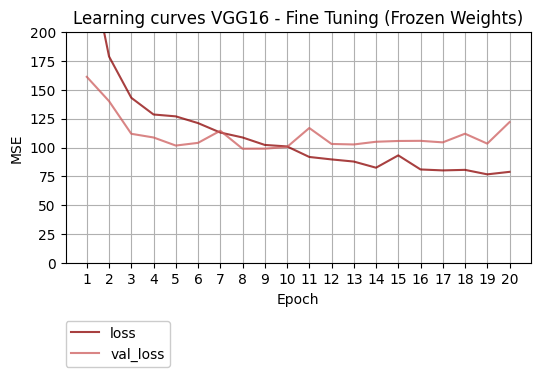

In [ ]:
# Plot of the training and validation loss before fine-tuning
plot_loss(history_finetuning,(0,200),'VGG16 - Fine Tuning (Frozen Weights)')

### 3.2.2. Second round : fine tuning the network

Our strategy is going to be to update the weights of the 3 last blocks of the original VGG16. 

**Why not training the whole pre-trained model?**

According to Chollett: 

* Earlier layers in the convolutional base encode more-generic, reusable features, whereas layers higher up encode more-specialized features. It’s more useful to fine-tune the more specialized features, because these are the ones that need to be repurposed on your new problem. There would be fast-decreasing returns in fine-tuning lower layers.

Besides the fact of the computational effort required to train the whole network

In [ ]:
# Set the base model to be trainable
base_model.trainable = True

# Fine-tune from block5_conv1, block5_conv2, block5_conv3 and onwards
set_trainable = False
for layer in base_model.layers:
    if layer.name in ('block5_conv1', 'block5_conv2', 'block5_conv3'):
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

# set 10 more epochs
epochs = 10

# recompile the model
VGG16_ft.compile(
    optimizer=optimizers.Adam(learning_rate=lr),
    loss = losses.MeanSquaredError(),
    metrics=[metrics.MeanAbsoluteError(name='MAE'),
             metrics.MeanAbsolutePercentageError(name='MAPE'),
             metrics.RootMeanSquaredError(name='RMSE'),
             metrics.MeanSquaredLogarithmicError(name='MSLE')]
)

# Fit the model with fine-tuning
history_VGG16_finetuning = VGG16_ft.fit(
    train_images,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=val_images
    )

Epoch 1/10


2023-04-08 04:48:48.519085: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


81/81 [==============================] - ETA: 0s - loss: 17541.0957 - MAE: 36.9434 - MAPE: 377.7925 - RMSE: 132.4428 - MSLE: 3.8452

2023-04-08 04:59:20.627244: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


81/81 [==============================] - 759s 9s/step - loss: 17541.0957 - MAE: 36.9434 - MAPE: 377.7925 - RMSE: 132.4428 - MSLE: 3.8452 - val_loss: 1063.0156 - val_MAE: 24.7138 - val_MAPE: 92.4633 - val_RMSE: 32.6039 - val_MSLE: 3.6921
Epoch 2/10
81/81 [==============================] - 787s 10s/step - loss: 1020.6818 - MAE: 24.2002 - MAPE: 90.9963 - RMSE: 31.9481 - MSLE: 3.5984 - val_loss: 1058.1814 - val_MAE: 24.6511 - val_MAPE: 93.5677 - val_RMSE: 32.5297 - val_MSLE: 3.6122
Epoch 3/10
81/81 [==============================] - 771s 10s/step - loss: 1015.2141 - MAE: 24.1249 - MAPE: 92.0595 - RMSE: 31.8624 - MSLE: 3.5088 - val_loss: 1052.0383 - val_MAE: 24.5710 - val_MAPE: 94.9779 - val_RMSE: 32.4351 - val_MSLE: 3.5151
Epoch 4/10
81/81 [==============================] - 779s 10s/step - loss: 1008.6667 - MAE: 24.0368 - MAPE: 93.4533 - RMSE: 31.7595 - MSLE: 3.4069 - val_loss: 1044.8331 - val_MAE: 24.4810 - val_MAPE: 96.7910 - val_RMSE: 32.3239 - val_MSLE: 3.4071
Epoch 5/10
81/81 [=======

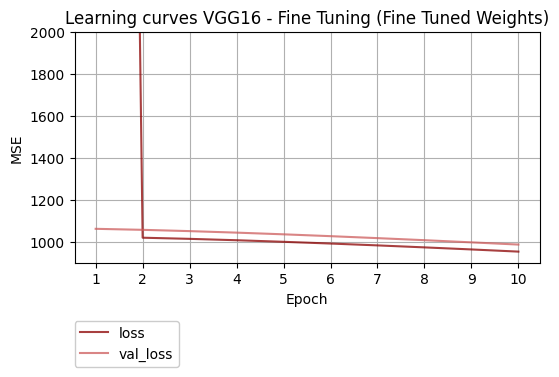

In [ ]:
# Plot of the training and validation loss after fine-tuning
plot_loss(history_VGG16_finetuning,(900,2000),'VGG16 - Fine Tuning (Fine Tuned Weights)')

In [ ]:
# VGG16_ft.save('vgg16_ft')

2023-04-08 10:01:39.986686: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,?,512]
	 [[{{node inputs}}]]
2023-04-08 10:01:39.999963: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,10]
	 [[{{node inputs}}]]
2023-04-08 10:01:41.043102: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,?,512]
	 [[{{node inputs}}]]
2023-04-0

INFO:tensorflow:Assets written to: vgg16_ft/assets


INFO:tensorflow:Assets written to: vgg16_ft/assets


### 3.2.3. Conclusion

The fine tuning did not go as expected. We observed very bad results after a very long time of running. One possible hypothesis is that we might have messed with the weights of the original network or chosen a large learning rate. Since this process was too expensive, we have decided to don't proceed with this fine tuning idea anymore.

# 4. Final model training

This final step is training our final model based on the best one found in 3.1.5. with the whole training set (train + validation) and save this model to the next notebook of comparison of all models.

## 4.1. Feature extraction

In [ ]:
# Pretrained model loading
pretrained_model = load_pretrained(VGG16)

# Extract features from pretrained model (convolution base)
train_full_features , train_full_labels = extract_features(pretrained_model,train_full_images)


1/1 [==============================] - 2s 2s/step


## 4.2. Model training

In [ ]:
# Build the model
denser_layers_config_best = ((1,32),)
params = {
    'lambda_' : 0,
    'dp_rate' : 0.2,
    'dense_layers_config' : denser_layers_config_best,
    'has_max_pooling' : True,
    'seed' : 0}
vgg16_final = PreTrained(**params)
vgg16_final.build(input_shape=pretrained_model.layers[-1].output_shape)
vgg16_final.summary()


Model: "pre_trained_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 max_pooling2d_9 (MaxPooling  multiple                 0         
 2D)                                                             
                                                                 
 dense_52 (Dense)            multiple                  147488    
                                                                 
 dropout_16 (Dropout)        multiple                  0         
                                                                 
 dense_53 (Dense)            multiple                  33        
                                                                 
 flatten_21 (Flatten)        multiple                  0         
                                                                 
Total params: 147,521
Trainable params: 147,521
Non-trainable params: 0
______________________________________________

In [ ]:
lr = 0.005
epochs = 20
batch_size = 64

vgg16_final.compile(
    optimizer=optimizers.Adam(learning_rate=lr),
    loss = losses.MeanSquaredError(),
    metrics=[metrics.MeanAbsoluteError(name='MAE'),
             metrics.MeanAbsolutePercentageError(name='MAPE'),
             metrics.RootMeanSquaredError(name='RMSE'),
             metrics.MeanSquaredLogarithmicError(name='MSLE')]
)

history_vgg_final = vgg16_final.fit(train_full_features,train_full_labels,
                                epochs=epochs,
                                batch_size=batch_size,
                                validation_data=(test_features,test_labels))

Epoch 1/20
101/101 [==============================] - 1s 7ms/step - loss: 274.7154 - MAE: 12.5140 - MAPE: 197.5779 - RMSE: 16.5745 - MSLE: 0.8500 - val_loss: 193.5044 - val_MAE: 9.9212 - val_MAPE: 79.9491 - val_RMSE: 13.9106 - val_MSLE: 0.3914
Epoch 2/20
101/101 [==============================] - 0s 4ms/step - loss: 161.7236 - MAE: 9.3096 - MAPE: 106.5901 - RMSE: 12.7171 - MSLE: 0.4282 - val_loss: 143.7798 - val_MAE: 8.5167 - val_MAPE: 74.0525 - val_RMSE: 11.9908 - val_MSLE: 0.3399
Epoch 3/20
101/101 [==============================] - 0s 4ms/step - loss: 139.3984 - MAE: 8.5680 - MAPE: 90.0317 - RMSE: 11.8067 - MSLE: 0.3684 - val_loss: 126.4947 - val_MAE: 7.9246 - val_MAPE: 75.7286 - val_RMSE: 11.2470 - val_MSLE: 0.2933
Epoch 4/20
101/101 [==============================] - 1s 5ms/step - loss: 127.4910 - MAE: 8.1245 - MAPE: 80.0267 - RMSE: 11.2912 - MSLE: 0.3292 - val_loss: 118.2072 - val_MAE: 7.8735 - val_MAPE: 86.7608 - val_RMSE: 10.8723 - val_MSLE: 0.3206
Epoch 5/20
101/101 [=========

## 4.3. Saving models

In [ ]:
# Saves the best model as .keras file.
history_vgg_final.model.save(filepath=path_save_model + "/pretrained_VGG", 
                    overwrite=True, 
                    save_format="keras")

print(f"VGG16 saved successfully into {path_save_model}")

2023-04-08 13:50:17.274091: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,32]
	 [[{{node inputs}}]]
2023-04-08 13:50:17.472587: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,32]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: /Users/maxwell.marcos/Documents/dev/FacialAgeProject/models/best_models/pretrained_VGG/assets


INFO:tensorflow:Assets written to: /Users/maxwell.marcos/Documents/dev/FacialAgeProject/models/best_models/pretrained_VGG/assets


VGG16 saved successfully into /Users/maxwell.marcos/Documents/dev/FacialAgeProject/models/best_models


In [ ]:
# Save the history dictionary of our best model.
import pickle
name_file = 'pretrained_VGG.pkl'
save_object = history_vgg_final.history
save_path = os.path.join(path_save_model, "pretrained_VGG", name_file)
with open(save_path, 'wb') as fp:
    pickle.dump(save_object, fp)
    print(f'{name_file} saved successfully into {path_save_model}')

pretrained_VGG.pkl saved successfully into /Users/maxwell.marcos/Documents/dev/FacialAgeProject/models/best_models
